## server python3.6.1 tensorflow-gpu 1.12.0


In [1]:
%matplotlib inline
from platform import python_version
print(python_version())

import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage

import keras

import keras.utils as Kutils
import keras.backend as K
from sklearn.metrics.pairwise import pairwise_distances

np.random.seed(120671)        

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
print('tf:',tf.__version__)
# import tensorflow as tf #tensorglow-gpu <1.14
# import tensorflow.compat.v1 as tf #tensorglow-gpu >1.14
# tf.disable_v2_behavior()

from keras.backend import set_session,tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)) 
config.gpu_options.per_process_gpu_memory_fraction = 0.9 
set_session(tf.Session(config=config))

3.6.1


Using TensorFlow backend.


tf: 1.12.0


---
## build model

In [2]:

from keras.models import Model
from keras import optimizers
import keras.layers as kl

from keras.legacy import interfaces
from keras.optimizers import Optimizer

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization

In [3]:
def triplet_loss_v1(y_true, y_pred):
    margin = K.constant(0.6)
    return K.mean(K.maximum(K.constant(0), 
                            K.square(y_pred[:,0,0]) - K.square(y_pred[:,1,0]) + margin))

def triplet_loss_v2(y_true, y_pred):
    margin = K.constant(1)
    return K.mean(K.maximum(K.constant(0), K.square(y_pred[:,0,0]) - 0.5*(K.square(y_pred[:,1,0])+K.square(y_pred[:,2,0])) + margin))


def accuracy(y_true, y_pred):
    return K.mean(y_pred[:,0,0] < y_pred[:,1,0])

def l2Norm(x):
    return  K.l2_normalize(x, axis=-1)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))



def softmax_weights(dist,axis=-1):
    #ndim = K.ndim(dist)
#     ndim=3
#     if ndim == 2:
#         return K.softmax(dist)
#     elif ndim > 2:
    e = K.exp(dist - K.max(dist, axis=axis, keepdims=True))
    s = K.sum(e, axis=axis, keepdims=True)
    return e / (s+ 1e-6)

def weighted_triplet_loss(y_true, y_pred, margin_type =  'softplus'):
    pos = y_pred[:,0,:]
    neg = y_pred[:,1,:]
    
    m_constant = 0.2#0.2

    
    w1 = softmax_weights(pos)
    w2 = softmax_weights(-neg)
    
    w1 = tf.cast(w1, tf.float32)
    w2 = tf.cast(w2, tf.float32)

    margin = m_constant * (K.square(pos * w1))

    loss_p = (K.square(pos * w1))
    loss_n = (K.square(neg * w2))

    loss = loss_p - loss_n + margin

    if margin_type == 'maxplus':
        L3 = K.maximum(0.0, loss)
    elif margin_type == 'softplus':
        L3 = K.softplus(loss)  # K.log(1 + K.exp(loss+margin)) #

    return K.mean(L3)



In [4]:
def dtw_distance(vects):
    x, y = vects
    return caculate_two_imgs(x,y) 

def empty_list_mat(n=8,m=8):
    test_list = []
    for i in range(n):
        test_list2 = []
        for j in range(m):
            test_list2.append(None)
        test_list.append(test_list2)
    return test_list


def caculate_two_imgs(a1, a2):
    tensor_shape = a1.shape
    dtw_range = tensor_shape[1]
    dist = []#np.zeros([dtw_range,dtw_range]) #np.zeros((ash[0],ash[1],ash[1]))

    for i in range(dtw_range):
        dist_a = []
        temp_feat1 = a1[:,i,:]
        for j in range(dtw_range):
            temp_feat2 = a2[:,j,:]
            testa =euclidean_distance([temp_feat1,temp_feat2])
            dist_a.append(testa)
        dist.append(dist_a)
    d = dtw_tensor(dist)
    return d


def dtw_tensor(dist_mat):
    m = len(dist_mat)
    n = len(dist_mat[0])
    dist = empty_list_mat(n,m)
    for i in range(m):
        for j in range(n):
            if (i == 0) and (j == 0):
                dist[i][j] = dist_mat[i][j]
            elif (i == 0) and (j > 0):
                dist[i][j] = dist[i][j-1] + dist_mat[i][j]
            elif (i > 0) and (j == 0):
                dist[i][j] = dist[i-1][j] + dist_mat[i][j]
            else:
                dist_min = K.min(K.stack([dist[i - 1][j], dist[i][j - 1]],axis=0),axis=0,keepdims=False)
                dist[i][j] =dist_min+ dist_mat[i][j] 
    return dist[-1][-1]/sum((n,m))

print('done')

done


In [5]:
import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape


# BatchNormalization=GroupNormalization

def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)



def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=False,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):

    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    print('final_pooling',final_pooling)
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model


def ResNet18(input_shape, classes):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])


In [6]:
# GLOBAL DEFINES
T_G_WIDTH = 224#32
T_G_HEIGHT = 224#32
T_G_NUMCHANNELS = 3
T_G_SEED = 1337

emb_size=256

In [7]:
# from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Conv2D,Dropout, Flatten, Dense,Input,AveragePooling2D,MaxPooling2D,Reshape
from keras.initializers import RandomNormal

In [56]:
try:
    del resnet_model
    print('del resnet_model')
except:
    pass

In [57]:
resnet_model = ResNet18(input_shape=(T_G_HEIGHT,T_G_WIDTH,3),classes=843)

for li,layer in enumerate(resnet_model.layers):
    layer.trainable = True

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
final_pooling None


In [10]:
#resnet_model.summary()

In [11]:
# for ri,rd in enumerate(resnet_model.layers):
#     print(ri,rd.output.shape)

---
input data

In [58]:
input_shape=(T_G_HEIGHT, T_G_WIDTH,T_G_NUMCHANNELS)
input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

---
### dtw local feature

In [59]:
from keras_radam import RAdam

In [60]:
##local feature

# New Layers over ResNet50
net = resnet_model.layers[51].output  #resnet_model.get_layer('activation_13').output #.output

net = Conv2D(filters = 128, kernel_size = (1,1), strides = (1,1), padding = 'same', kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(net)
net = Activation('relu')(net)
net = kl.Dropout(0.75)(net)
net = kl.BatchNormalization()(net)
net = MaxPooling2D(pool_size=(1,7))(net)

net = kl.Lambda(l2Norm, output_shape=[7,1,128])(net)
net = kl.Reshape((7,128))(net)

dtw_triplet_model = Model(resnet_model.input, net, name="dtw_triplet_model")
net_dtw_anchor = dtw_triplet_model(input_anchor)
net_dtw_positive = dtw_triplet_model(input_positive)
net_dtw_negative = dtw_triplet_model(input_negative)

##dtw_distance
positive_dtw_dist = kl.Lambda(dtw_distance)([net_dtw_anchor, net_dtw_positive])
negative_dtw_dist = kl.Lambda(dtw_distance)([net_dtw_anchor, net_dtw_negative])
# tertiary_dtw_dist = kl.Lambda(dtw_distance)([net_dtw_positive, net_dtw_negative])

print(positive_dtw_dist)
# This lambda layer simply stacks outputs so both distances are available to the objective
stacked_dtw_dists = kl.Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_dtw_dists')([positive_dtw_dist, negative_dtw_dist])#,tertiary_dtw_dist])#, tertiary_dist2])


model_local = Model([input_anchor, input_positive,input_negative], 
              [stacked_dtw_dists],
              name='dtw_triplet_model')
    
for li,layer in enumerate(model_local.layers):
    layer.trainable = True

Tensor("lambda_10/truediv:0", shape=(?, 1), dtype=float32)


---
### global feature

In [61]:
## gobal feature

# New Layers over ResNet50
net2 = resnet_model.layers[51].output #resnet_model.output # resnet_model.get_layer('activation_13').output #.output
net2 = kl.Flatten(name='flatten')(net2)
net2 = kl.Lambda(lambda  x: K.l2_normalize(x,axis=1))(net2)

# model creation
triplet_model = Model(resnet_model.input, net2, name="triplet_model")

net_anchor = triplet_model(input_anchor)
net_positive = triplet_model(input_positive)
net_negative = triplet_model(input_negative)

# The Lamda layer produces output using given function. Here its Euclidean distance.
positive_dist = kl.Lambda(euclidean_distance, name='pos_dist')([net_anchor, net_positive])
negative_dist = kl.Lambda(euclidean_distance, name='neg_dist')([net_anchor, net_negative])
tertiary_dist = kl.Lambda(euclidean_distance, name='ter_dist')([net_positive, net_negative])

# This lambda layer simply stacks outputs so both distances are available to the objective
stacked_dists = kl.Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_dists')([positive_dist, negative_dist])#, tertiary_dist])

model_global = Model([input_anchor, input_positive,input_negative], 
              [stacked_dists],
              name='triplet_model')

for li,layer in enumerate(model_global.layers):
    layer.trainable = True

---
test stack

In [62]:
# sum_pos_dist = keras.layers.add([positive_dist, positive_dtw_dist])
# sum_neg_dist =  keras.layers.add([negative_dist,negative_dtw_dist])
# sum_tertiary_dist =  keras.layers.add([tertiary_dist,tertiary_dtw_dist])

# stacked_sum_dists = kl.Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_sum_dists')([sum_pos_dist, sum_neg_dist])#,sum_tertiary_dist])
# print(stacked_sum_dists)

# model = Model([input_anchor, input_positive,input_negative], 
#               [stacked_sum_dists],
#               name='dtw_triplet_model')


# for li,layer in enumerate(resnet_model.layers):
#     layer.trainable = True
    
# for li,layer in enumerate(model.layers):
#     layer.trainable = True
    
# losses = {"stacked_sum_dists":triplet_loss_v1}  # weighted_triplet_loss}
# accuracies = {"stacked_sum_dists":accuracy}

# opt=keras.optimizers.Adam(lr=0.001) # Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# model.compile(loss=losses,
#               optimizer=opt,
#               metrics=accuracies)
# print('done')

---

### combine local and global model 

In [63]:
model = Model([input_anchor, input_positive,input_negative], 
              [stacked_dtw_dists,stacked_dists],
              name='triplet_model')

for li,layer in enumerate(model.layers):
    # comment this out to refine earlier layers
    layer.trainable = True

---
# load datasets

In [64]:
### imgaug

import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.8, aug)
sometimes2 = lambda aug: iaa.Sometimes(0.2, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.4), # horizontally flip 50% of the images
    
    # crop images by -5% to 10% of their height/width
    #sometimes2(iaa.Crop(px=(0, 5))), # crop images from each side by 0 to 16px (randomly chosen)
    sometimes2(iaa.GaussianBlur(sigma=(0, 0.2))), # blur images with a sigma of 0 to 3.0
    
    sometimes2(iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
            #translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-5, 5), # rotate by -45 to +45 degrees
            shear=(-5, 5))
             ),
    
    sometimes(iaa.CoarseDropout(p=0.1, size_percent=0.1)),
    sometimes(iaa.GammaContrast((0.7,1.2)))

])


In [65]:

import os
# from matplotlib.image import imread
import cv2
import numpy as np

import keras.utils as Kutils

def normalize(x_):
    x = x_.copy()
    del x_
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x - min_val) / (max_val - min_val)
    return x

def normalize_v2(x_):
    print(x_.shape)
    cv_img = x_.copy()
    del x_
    
    #cv_img = cv2.medianBlur(cv_img,7)
    
    #t1 = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    print(cv_img.shape)
    t1 =cv_img/255.
    t1[:,:,0] = ( t1[:,:,0] - 0.485)/0.229
    t1[:,:,1] = ( t1[:,:,1] - 0.456)/0.224
    t1[:,:,2] =  (t1[:,:,2] - 0.406)/0.225
    return t1


def norm_test1(x_):
    img = x_.copy()#.astype(np.float32)#/255.0
    del x_
    img = img.astype("float32")
    img /= 127.5
    img -= 1.
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#.astype(np.float32)/255.0
    #img = img.astype("float32")
    #img = keras.applications.resnet50.preprocess_input(img,mode='tf', data_format='channels_last')
    
    return img

class PreProcessing:

    images_train = np.array([])
    images_test = np.array([])
    labels_train = np.array([])
    labels_test = np.array([])
    unique_train_label = np.array([])
    map_train_label_indices = dict()

    def __init__(self, h=32, w=32, train_test_ratio=0.9, data_set=None, 
                 data_src=None,dataset_type='default'):
        print('h, w',h, w)
        self.h, self.w = h, w
        
        self.data_set = data_set
        self.data_src = data_src
        self.dataset_type = dataset_type
        
        #self.num_classes = num_classes
        print("Loading Geological Similarity Dataset...")
        self.images_train, self.images_test, self.labels_train, self.labels_test = self.preprocessing(train_test_ratio)
        self.unique_train_label = np.unique(self.labels_train)
        self.map_train_label_indices = {label: np.flatnonzero(self.labels_train == label) for label in
                                        self.unique_train_label}
        
        self.unique_test_label = np.unique(self.labels_test)
        self.map_test_label_indices = {label: np.flatnonzero(self.labels_test == label) for label in
                                        self.unique_test_label}
        
        
        print('Preprocessing Done. Summary:')
        print("Images train :", self.images_train.shape)
        print("Labels train :", self.labels_train.shape)
        print("Images test  :", self.images_test.shape)
        print("Labels test  :", self.labels_test.shape)
        print("Unique label :%s , , ,%s" %(self.unique_train_label[0],self.unique_train_label[-1]))
        
        self.num_classes = len(self.unique_train_label)
        print('num_classes',self.num_classes)

#     def normalize(self,x):
#         min_val = np.min(x)
#         max_val = np.max(x)
#         x = (x - min_val) / (max_val - min_val)
#         return x

    def read_dataset(self):
        X = []
        y = []
        
        included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']
        for directory in os.listdir(self.data_src):
            try:
                for pic in os.listdir(os.path.join(self.data_src, directory)):
                    if any(pic.endswith(ext) for ext in included_extensions):
                        #img = imread(os.path.join(self.data_src, directory, pic))
                        img_path = os.path.join(self.data_src, directory, pic)
                        img=cv2.imread(img_path)
                        
                        img = cv2.resize(img,(self.w, self.h))
                        X.append(np.squeeze(np.asarray(img)))
                        y.append(directory)
                    else:
                        continue
            except Exception as e:
                print('Failed to read images from Directory: ', directory)
                print('Exception Message: ', e)
        print('Dataset loaded successfully.')
        return X,y
    
    def read_dataset_cuhk(self):
        X = []
        y = []

        included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']
        
        #tidx=0
        for img_name in os.listdir(self.data_src):
            #tidx+=1
            #if tidx>20:
            #    break
            try:
                #print('img_name:',img_name)
                img_index = img_name.split('_')[1]
                #print(img_index)

                if any(img_name.endswith(ext) for ext in included_extensions):
                    full_img_path = os.path.join(self.data_src, img_name)
                    if os.path.isfile(full_img_path):
                        img = cv2.cvtColor(cv2.imread(full_img_path), cv2.COLOR_BGR2RGB)#.astype(np.float32)/255.0
                        img = cv2.resize(img,(self.w, self.h))
                        X.append(np.squeeze(np.asarray(img)))
                        y.append(int(img_index))
                        
            except Exception as e:
                print('Failed to read images from Directory: ', directory)
                print('Exception Message: ', e)
                
        return X,y
        
    def dataset_resize(self):
        X,y = self.data_set
    
    def dataset_resize(self):
        X,y = self.data_set
        
        nX =[]
        for x in X:
            nx = cv2.resize(x,(self.w, self.h))
            nX.append(nx)
            
        return np.array(nX), y
        
    def preprocessing(self,train_test_ratio):
        if self.data_src is not None:
            if self.dataset_type=='cuhk':
                X, y = self.read_dataset_cuhk()
            else:
                X, y = self.read_dataset()
        else:
            X,y = self.dataset_resize()#self.data_set
            
        #print('y',y[:10])
            
        labels = list(set(y))
        label_dict = dict(zip(labels, range(len(labels))))
        Y = np.asarray([label_dict[label] for label in y])
        #X = [self.normalize(x) for x in X]                                  # normalize images

        shuffle_indices = np.random.permutation(np.arange(len(y)))
        x_shuffled = []
        y_shuffled = []
        for index in shuffle_indices:
            x_shuffled.append(X[index])
            y_shuffled.append(Y[index])

        size_of_dataset = len(x_shuffled)
        n_train = int(np.ceil(size_of_dataset * train_test_ratio))
        return np.asarray(x_shuffled[0:n_train]), np.asarray(x_shuffled[n_train + 1:size_of_dataset]), np.asarray(
            y_shuffled[0:n_train]), np.asarray(y_shuffled[
                                               n_train + 1:size_of_dataset])


    def get_triplets(self, train_mode=True):
        
        if train_mode:
            unique_label= self.unique_train_label
            map_label_indices = self.map_train_label_indices
        else:
            unique_label= self.unique_test_label
            map_label_indices = self.map_test_label_indices        
            
        label_l, label_r = np.random.choice(unique_label, 2, replace=False)
        
        if len(map_label_indices[label_l])<2:
            a=map_label_indices[label_l][0]
            p=a
        else:
            a, p = np.random.choice(map_label_indices[label_l],2, replace=False)
            
        n = np.random.choice(map_label_indices[label_r])
        
        #print('a, p, n',a, p, n)
        return a, p, n,  label_l

    def get_triplets_batch(self,n, train_mode=True):
        idxs_a, idxs_p, idxs_n, label_a = [], [], [], []
        for _ in range(n):
            a, p, n, l_a = self.get_triplets(train_mode)
            idxs_a.append(a)
            idxs_p.append(p)
            idxs_n.append(n)
            label_a.append(l_a)
            
        catg_y = Kutils.to_categorical(np.array(label_a), self.num_classes)
            
        if train_mode:
            return self.images_train[idxs_a,:], self.images_train[idxs_p, :], self.images_train[idxs_n, :],catg_y
        else:
            return self.images_test[idxs_a,:], self.images_test[idxs_p, :], self.images_test[idxs_n, :], catg_y
    



In [66]:
## cuhk03_labeled dataset
# data_dir='/Datasets/cuhk03_labeled'
# prep = PreProcessing(h=224,w=224, train_test_ratio=0.9,data_set=None, data_src=data_dir, dataset_type='cuhk')
# next_batch = prep.get_triplets_batch

In [126]:
# market1501 dataset
"""
train_all
...0002
......0002_c1_f0000451_03.jpg
......0002_c1_f0000551_01.jpg
...........
...0007
.
.
.
"""

data_dir='/root/heidi/train_all'
prep = PreProcessing(h=224,w=224, train_test_ratio=0.9,data_set=None, data_src=data_dir,dataset_type='default')
next_batch = prep.get_triplets_batch

h, w 224 224
Loading Geological Similarity Dataset...
Dataset loaded successfully.
Preprocessing Done. Summary:
Images train : (11643, 224, 224, 3)
Labels train : (11643,)
Images test  : (1292, 224, 224, 3)
Labels test  : (1292,)
Unique label :0 , , ,750
num_classes 751


In [68]:
## get validation datasets
v_batch_n=800
val_anchor_, val_positive_, val_negative_, val_a_label = next_batch(v_batch_n,False)
val_anchor_y = np.random.randint(2, size=(1,2,val_anchor_.shape[0])).T

val_anchor=norm_test1(val_anchor_)
val_positive=norm_test1(val_positive_)
val_negative=norm_test1(val_negative_)

val_anchor_aug_ = seq.augment_images(val_anchor_)
val_positive_aug_ = seq.augment_images(val_positive_)
val_negative_aug_ = seq.augment_images(val_negative_)

val_anchor_aug=norm_test1(val_anchor_aug_)
val_positive_aug=norm_test1(val_positive_aug_)
val_negative_aug=norm_test1(val_negative_aug_)

In [29]:
## for multi gpu
# from keras.utils.training_utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=4)

# model.compile(loss=losses,
#               optimizer=opt,
#               metrics=accuracies)

---
### compile and training learning rate test

In [69]:
#opt=keras.optimizers.Adam(lr=0.02) # Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
opt=RAdam(warmup_proportion=0.3, min_lr=0.1)

losses = {"stacked_dtw_dists":triplet_loss_v1}  # weighted_triplet_loss}
accuracies = {"stacked_dtw_dists":accuracy}

model_local.compile(loss=losses,
              optimizer=opt,
              metrics=accuracies,loss_weights=[1.0])

# opt=keras.optimizers.Adam(lr=0.02) # Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
opt=RAdam( warmup_proportion=0.2, min_lr=0.02)
losses = {"stacked_dists":triplet_loss_v1}  # weighted_triplet_loss}
accuracies = {"stacked_dists":accuracy}

model_global.compile(loss=losses,
              optimizer=opt,
              metrics=accuracies,loss_weights=[1.0])



In [70]:
losses = {"stacked_dtw_dists":triplet_loss_v1,
          "stacked_dists": triplet_loss_v1}

accuracies = {"stacked_dtw_dists":accuracy,
              "stacked_dists": accuracy}

opt=keras.optimizers.Adam(lr=0.01) # Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(loss=losses,
              optimizer=opt,
              metrics=accuracies,loss_weights=[1.0,1.0])
print('done')

done


In [24]:
val_hist = model.evaluate([val_anchor, val_positive, val_negative], [val_anchor_y,val_anchor_y], batch_size = 5)
print(val_hist)

800/800 [==============================] - 11s 14ms/step
[1.39681945592165, 0.5392256287857891, 0.3709114014171064, 0.8762500071898103, 0.8662500069476664]


predict_result가 동일한 값으로 출력되면 learning rate를 조정하고

모델(어차피 resnet공유함)을개별적으로 학습시킨다.


In [72]:

batch_size=32
for tei_ in range(50):
    print(tei_)
    batch_anchor, batch_positive, batch_negative, batch_a_label = next_batch(batch_size)
    batch_anchor2 = norm_test1(batch_anchor)
    batch_positive2 = norm_test1(batch_positive)
    batch_negative2 = norm_test1(batch_negative)

    batch_anchor_y = np.random.randint(2, size=(1,2,batch_anchor.shape[0])).T

    hist = model_global.fit([batch_anchor2, batch_positive2, batch_negative2],
                     batch_anchor_y,
                     steps_per_epoch=int(len(batch_a_label)/ batch_size),
                     shuffle=False,epochs=2,verbose=2)
    
    hist1 = model_local.fit([batch_anchor2, batch_positive2, batch_negative2],
                     batch_anchor_y,
                     steps_per_epoch=int(len(batch_a_label)/ batch_size),
                     shuffle=False,epochs=2,verbose=2)
    
    predict_result =model.predict([batch_anchor2[:2], batch_negative2[:2], batch_positive2[:2]])
    print('---')
    print('predict_result',predict_result[:2])

0
Epoch 1/2
 - 0s - loss: 0.5849 - accuracy: 0.8750
Epoch 2/2
 - 0s - loss: 0.5725 - accuracy: 0.9062
Epoch 1/2
 - 0s - loss: 0.7089 - accuracy: 0.8750
Epoch 2/2
 - 0s - loss: 0.7106 - accuracy: 0.8750
---
predict_result [array([[[0.59608936],
        [0.43336108]],

       [[0.79778653],
        [0.5966437 ]]], dtype=float32), array([[[1.1632859],
        [0.6986174]],

       [[1.1616398],
        [0.8809837]]], dtype=float32)]
1
Epoch 1/2
 - 0s - loss: 0.5282 - accuracy: 1.0000
Epoch 2/2
 - 0s - loss: 0.5213 - accuracy: 1.0000
Epoch 1/2
 - 0s - loss: 0.6310 - accuracy: 0.9375
Epoch 2/2
 - 0s - loss: 0.6354 - accuracy: 0.9375
---
predict_result [array([[[0.6007116 ],
        [0.16452453]],

       [[1.0460119 ],
        [0.34959778]]], dtype=float32), array([[[1.1162207 ],
        [0.37519366]],

       [[1.4780889 ],
        [0.6825701 ]]], dtype=float32)]
2
Epoch 1/2
 - 0s - loss: 0.4892 - accuracy: 1.0000
Epoch 2/2
 - 0s - loss: 0.4835 - accuracy: 1.0000
Epoch 1/2
 - 0s - loss: 0.

---
# training model

In [110]:
traind_model_name ="./best_model/1001/1011_resnet_model_global_market_"
# model.save("{}{}.h5".format(traind_model_name,'0'))

In [119]:
batch_size=32

val_list = []

# callback = keras.callbacks.LearningRateScheduler(lr_schedule)    

max_acc = 0.8
min_loss=4.0

In [120]:
for ei in range(5):
    
    batch_anchor, batch_positive, batch_negative, batch_a_label = next_batch(batch_size)
    batch_anchor_y = np.random.randint(2, size=(1,2,batch_anchor.shape[0])).T
   
    anchor_x = seq.augment_images(batch_anchor)
    pos_x = seq.augment_images(batch_positive)
    neg_x = seq.augment_images(batch_negative)
    
    batch_anchor=norm_test1(batch_anchor)
    batch_positive=norm_test1(batch_positive)
    batch_negative=norm_test1(batch_negative)
    
    anchor_x=norm_test1(anchor_x)
    pos_x=norm_test1(pos_x)
    neg_x=norm_test1(neg_x)   
    

    if ei%2==0:
        # original images
        hist = model_global.fit([batch_anchor, batch_positive, batch_negative],
                     batch_anchor_y,
                     steps_per_epoch=int(len(batch_a_label)/ batch_size),
                     shuffle=False,epochs=2,verbose=0)  #,callbacks=[callback])

        hist1 = model_local.fit([batch_anchor, batch_positive, batch_negative],
                         batch_anchor_y,
                         steps_per_epoch=int(len(batch_a_label)/ batch_size),
                         shuffle=False,epochs=2,verbose=0)  #,callbacks=[callback])
    
    
    # augment_images
    hist = model_global.fit([anchor_x, pos_x, neg_x],
                 batch_anchor_y,
                 steps_per_epoch=int(len(batch_a_label)/ batch_size),
                 shuffle=False,epochs=2,verbose=0)  #,callbacks=[callback])
    
    hist1 = model_local.fit([anchor_x, pos_x, neg_x],
                     batch_anchor_y,
                     steps_per_epoch=int(len(batch_a_label)/ batch_size),
                     shuffle=False,epochs=2,verbose=0)  #,callbacks=[callback])
        

    if ei%3==0:
        print('\nEpoch',ei)
        
        val_hist = model.evaluate([val_anchor_aug, val_positive_aug, val_negative_aug],
                                  [val_anchor_y,val_anchor_y],
                                  #[val_anchor_y,val_a_label], 
                                  batch_size = 5)
        
        val_list.append(val_hist)
        
        for hist_ in hist.history:
            print(hist_, hist.history[hist_][-1])
            
        vs=[]
        for val_hist_ in val_hist:
            vs.append(round(val_hist_,3))
        print('\nval_hist loss:{}\nval dtw loss: {},val global loss: {}\nval dtw acc: {}, val global acc: {}\n'.format(vs[0],vs[1],vs[2],vs[3],vs[4]))

        predict_result=model.predict([batch_anchor[:2], batch_positive[:2], batch_negative[:2]])
        if abs(predict_result[0][0][0]-predict_result[0][0][1]) <0.0001:
            print('You must adjust the learning rate. DTW model\n',predict_result[0])
            
        if abs(predict_result[1][0][0]-predict_result[1][0][1] )<0.0001:
            print('You must adjust the learning rate. Gobal model\n',predict_result[1])
            
    total_acc=(val_hist[3]+val_hist[4])/2
    if max_acc< total_acc and  min_loss> val_hist[0]:
        max_acc = total_acc
        print('min_loss',min_loss)
        print('max_acc,',max_acc)
        
        saved_w_name = "{}{}.h5".format(traind_model_name,int(max_acc*1000))
        #model.save_weights(saved_w_name)        
        model.save(saved_w_name)
        print("Saved model to disk:",saved_w_name)

        


Epoch 0
800/800 [==============================] - 6s 8ms/step
loss 0.31354546546936035
accuracy 0.9375

val_hist loss:0.801
val dtw loss: 0.324,val global loss: 0.252
val dtw acc: 0.819, val global acc: 0.829

min_loss 4.0
max_acc, 0.8237500088755041
Saved model to disk: ./best_model/1001/1011_resnet_model_global_market_823.h5

Epoch 3
800/800 [==============================] - 6s 8ms/step
loss 0.37683233618736267
accuracy 0.875

val_hist loss:0.818
val dtw loss: 0.326,val global loss: 0.269
val dtw acc: 0.87, val global acc: 0.878

min_loss 4.0
max_acc, 0.8737500070594251
Saved model to disk: ./best_model/1001/1011_resnet_model_global_market_873.h5


In [121]:
# print('min_loss',min_loss)
print('max_acc: ',max_acc)
print('last acc: ',val_hist[1])

max_acc:  0.8737500070594251
last acc:  0.32580578093402435


---
model result

dtwl result 


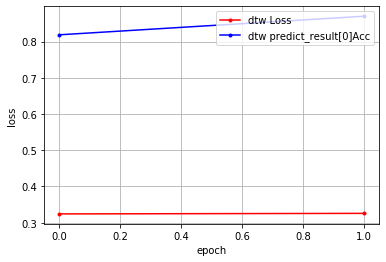


global result 


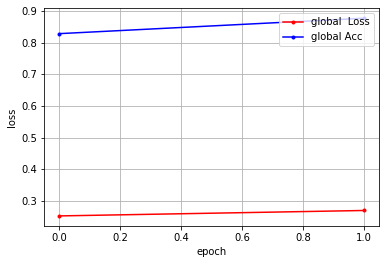

In [122]:
## dtw result 
print('dtwl result ')
y_vloss1 = np.array(val_list)[:,1]
y_acc1 = np.array(val_list)[:,3]

x_len = np.arange(len(y_vloss1))
plt.plot(x_len, y_vloss1, marker='.', c='red', label="dtw Loss")
plt.plot(x_len, y_acc1, marker='.', c='blue', label="dtw predict_result[0]Acc")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


## golbal result 
print('\nglobal result ')
y_vloss2 = np.array(val_list)[:,2]
y_acc2 = np.array(val_list)[:,4]

x_len = np.arange(len(y_vloss2))
plt.plot(x_len, y_vloss2, marker='.', c='red', label="global  Loss")
plt.plot(x_len, y_acc2, marker='.', c='blue', label="global Acc")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


---
test local dataset

In [123]:
import matplotlib.pyplot as plt
import cv2

from os import listdir
from os.path import isfile, join

test_imgs = '/root/heidi/0918'
onlyfiles = [f for f in listdir(test_imgs) if isfile(join(test_imgs, f))]
onlyfiles.sort()

0 /root/heidi/0918/0_1.jpg


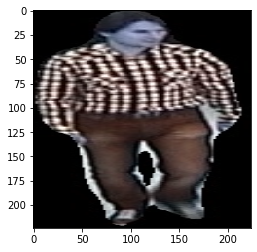

1 /root/heidi/0918/0_2.jpg


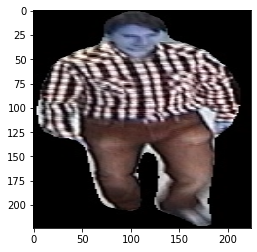

2 /root/heidi/0918/0_3.jpg


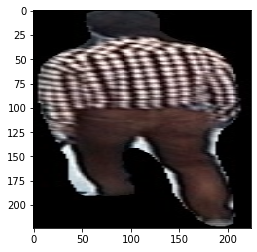

3 /root/heidi/0918/1_1.jpg


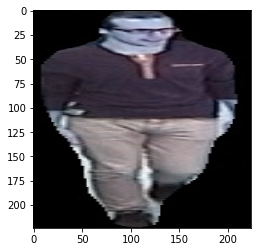

4 /root/heidi/0918/1_2.jpg


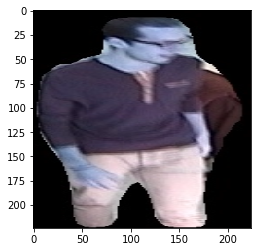

5 /root/heidi/0918/1_3.jpg


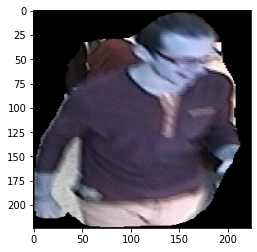

6 /root/heidi/0918/2_1.jpg


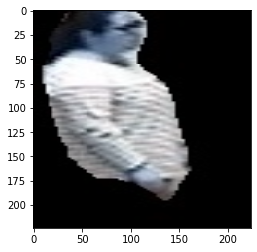

7 /root/heidi/0918/2_2.jpg


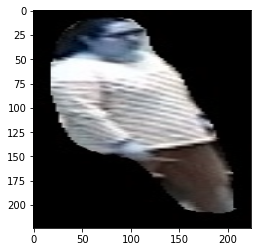

8 /root/heidi/0918/2_3.jpg


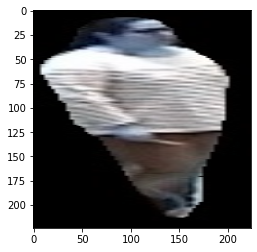

9 /root/heidi/0918/3_1.jpg


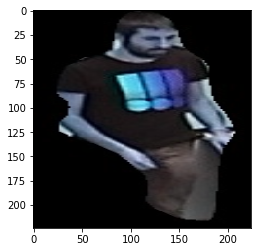

10 /root/heidi/0918/3_2.jpg


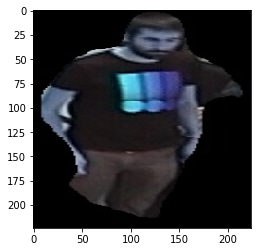

11 /root/heidi/0918/3_3.jpg


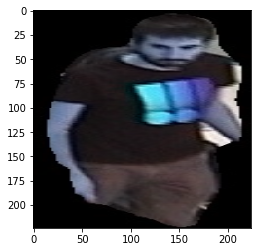

In [124]:
img_list =[]
for i,onlyfile in enumerate(onlyfiles):
    img_path  = join(test_imgs,onlyfile)
    print(i,img_path)
    img = cv2.imread(img_path)
    re_img = cv2.resize(img, (224,224))
    plt.imshow(re_img)
    plt.show()
    nor_img = norm_test1(re_img).reshape(-1,224,224,3)
    img_list.append(nor_img)

In [125]:
# pa2=loaded_model.predict([img_list[0], img_list[2],img_list[7]])
pa2=model.predict([img_list[0], img_list[2],img_list[7]])

print(pa2[0]+pa2[1])

[[[0.77277184]
  [2.034604  ]]]


---
### save model

In [45]:
saved_w_name = "{}{}_last.h5".format(traind_model_name,int(val_hist[1]*1000))
#model.save_weights(saved_w_name)        
model.save(saved_w_name)
print("Saved model to disk:",saved_w_name)

Saved model to disk: ./best_model/1001/1007_resnet_model_global_3_700_last.h5


---
### load model

In [69]:

#load model
from keras.models import load_model

traind_model_name ="./best_model/1001/1010_resnet_model_global_2_907.h5"
loaded_model = load_model(traind_model_name,custom_objects={'caculate_two_imgs':caculate_two_imgs,'triplet_loss_v1': triplet_loss_v1})

---